## Importing libraries

In [89]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler

import os

import sys

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy import signal

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model


In [2]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

## Importing my Classes :)

In [4]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [5]:
# Data Class
import DataClass 
from DataClass import Data

In [6]:
# read prepared data
data = Data( 0, "", "",parquet_path)

## Hybrid model (1) a little overfitted

In [47]:
# input data and label data
df_1 = data.scaled_stances_statics_df[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm']]
y_1 = data.scaled_stances_statics_df[[ 'y']]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, y_1, random_state=42)

In [63]:
train_seq=np.array(list(np.asarray(X_train_1['r_interp'])), dtype=float)
test_seq=np.array(list(np.asarray(X_test_1['r_interp'])), dtype=float)

In [64]:
# Reshape the sequences to be 3-dimensional (samples, timesteps, features)
X_train_seq = np.reshape( train_seq, (train_seq.shape[0],train_seq.shape[1], 1))
X_test_seq = np.reshape( test_seq, (test_seq.shape[0],test_seq.shape[1], 1))

In [70]:
itemized_train_data = X_train_1.drop('r_interp',axis=1)
itemized_train_data=itemized_train_data.to_numpy()
# itemized_train_data = np.asarray(itemized_train_data[:,:]).astype('float32')

In [72]:
itemized_test_data = X_test_1.drop('r_interp',axis=1)
itemized_test_data=itemized_test_data.to_numpy()

In [87]:
X_train_seq.shape

(13669, 100, 1)

In [71]:
itemized_train_data.shape

(13669, 3)

In [97]:
from keras.regularizers import l2

In [101]:
# Define the input shape for the CNN
num_sensors=1
input_shape = (X_train_seq.shape[1], num_sensors)


# Define the CNN model
cnn_input = Input(shape=input_shape)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
#conv4 = Conv1D(filters=512, kernel_size=3, activation='relu')(pool3)
#pool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(pool3)
cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
# cnn_output = Dense(128, activation='relu')(flatten)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Define the fully connected model

fc_input = Input(shape=(itemized_train_data.shape[1],))

concat = Concatenate()([cnn_output, fc_input])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
#dropout = Dropout(0.5)(dense1)
fc_output = Dense(1, activation='sigmoid')(dense2)

fc_model = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
fc_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = fc_model.fit([X_train_seq, itemized_train_data], y_train_1, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
342/342 [==============================] - 7s 17ms/step - loss: 1.4788 - accuracy: 0.6247 - val_loss: 0.5952 - val_accuracy: 0.6752
Epoch 2/50
342/342 [==============================] - 7s 19ms/step - loss: 0.7123 - accuracy: 0.6650 - val_loss: 0.6127 - val_accuracy: 0.6598
Epoch 3/50
342/342 [==============================] - 6s 18ms/step - loss: 0.6466 - accuracy: 0.6800 - val_loss: 0.8102 - val_accuracy: 0.6767
Epoch 4/50
342/342 [==============================] - 5s 16ms/step - loss: 0.6048 - accuracy: 0.7034 - val_loss: 0.5284 - val_accuracy: 0.7356
Epoch 5/50
342/342 [==============================] - 7s 21ms/step - loss: 0.6093 - accuracy: 0.7161 - val_loss: 1.0367 - val_accuracy: 0.4568
Epoch 6/50
342/342 [==============================] - 6s 16ms/step - loss: 0.5740 - accuracy: 0.7348 - val_loss: 0.6174 - val_accuracy: 0.6913
Epoch 7/50
342/342 [==============================] - 7s 20ms/step - loss: 0.5589 - accuracy: 0.7478 - val_loss: 0.4813 - val_accuracy: 0.7846

In [103]:
# Evaluate the performance of the model on the testing set
#X_test_seq = np.expand_dims(X_test.iloc[:,0].values, axis=2)
x_test_features = np.asarray(itemized_test_data[:,1:]).astype('float32')
accuracy = fc_model.evaluate([X_test_seq, itemized_test_data], y_test_1)[1]
print(f'Accuracy: {accuracy}')

143/143 [==============================] - 1s 5ms/step - loss: 0.4446 - accuracy: 0.8253
Accuracy: 0.8253237009048462


In [104]:
print(fc_model.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 98, 32)       128         ['input_11[0][0]']               
                                                                                                  
 max_pooling1d_17 (MaxPooling1D  (None, 49, 32)      0           ['conv1d_19[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 47, 64)       6208        ['max_pooling1d_17[0][0]']

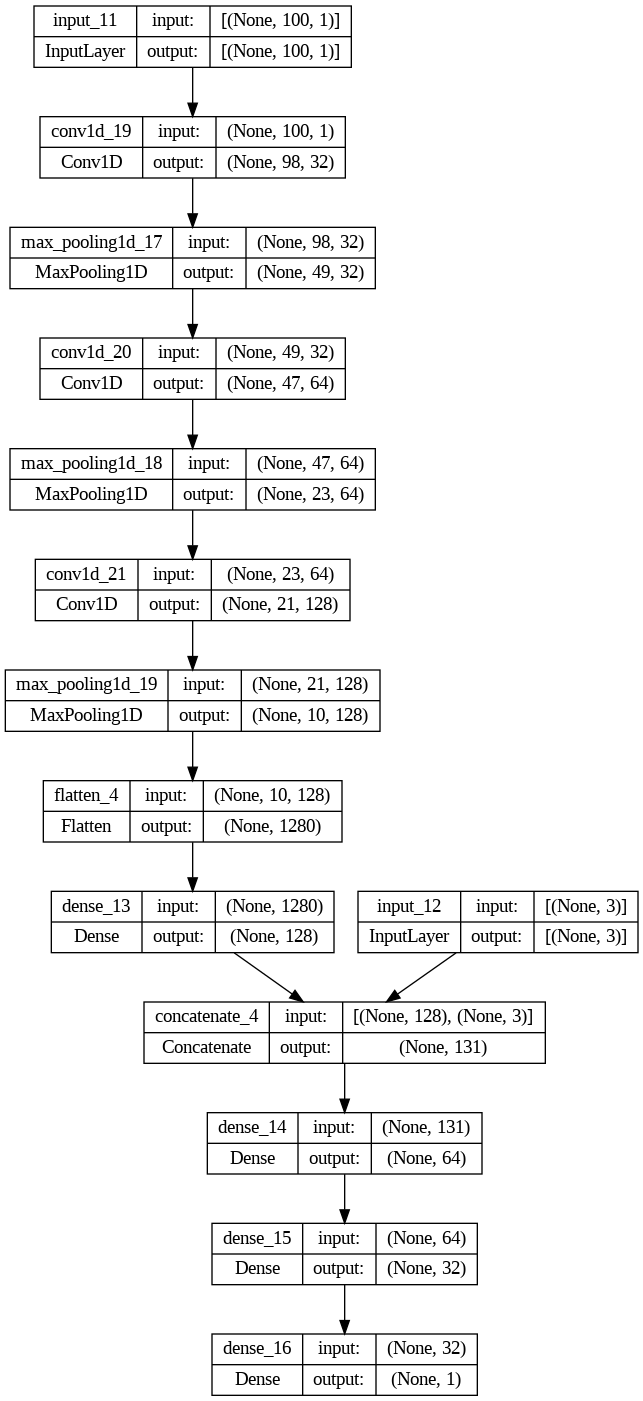

In [127]:
plot_model(fc_model, to_file="/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/hybrid_model_1_82.png", show_shapes=True,show_layer_names=True)

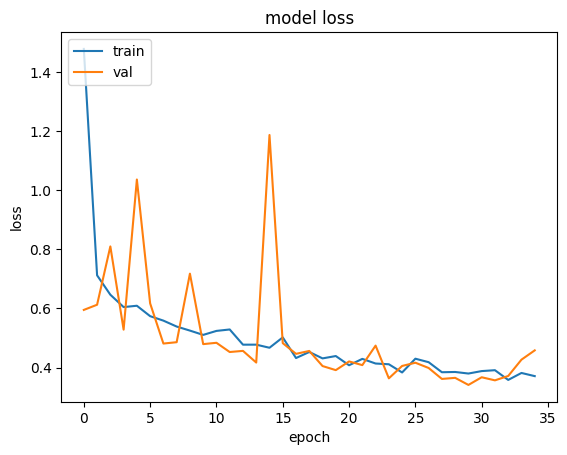

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

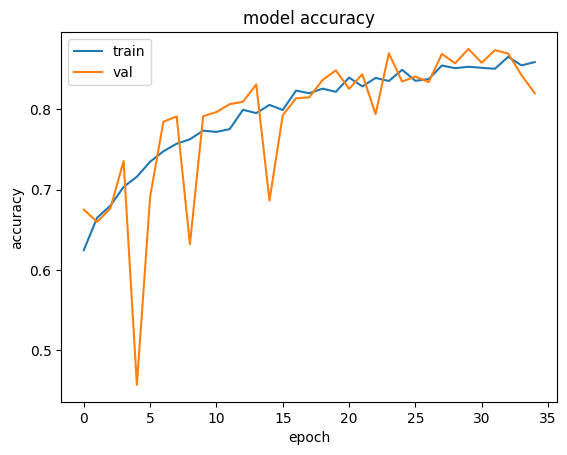

In [107]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
# save the model
fc_model.save(models_path+"hybrid_model_1_82")


In [129]:
# load the model
loaded_fc_model = keras.models.load_model(models_path+"hybrid_model_1_82")


In [131]:
# check the loaded model
accuracy = loaded_fc_model.evaluate([X_test_seq, itemized_test_data], y_test_1)[1]
print(f'Accuracy: {accuracy}')

143/143 [==============================] - 2s 9ms/step - loss: 0.4446 - accuracy: 0.8253
Accuracy: 0.8253237009048462


## Hybrid model (1.5) - model not saved

In [122]:
# Define the input shape for the CNN
num_sensors=1
input_shape = (X_train_seq.shape[1], num_sensors)


# Define the CNN model
cnn_input = Input(shape=input_shape)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
#conv4 = Conv1D(filters=512, kernel_size=3, activation='relu')(pool3)
#pool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(pool3)
cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
# cnn_output = Dense(128, activation='relu')(flatten)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Define the fully connected model

fc_input = Input(shape=(itemized_train_data.shape[1],))

concat = Concatenate()([cnn_output, fc_input])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
#dropout = Dropout(0.5)(dense1)
fc_output = Dense(1, activation='sigmoid')(dense2)

fc_model_2 = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
fc_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_2 = fc_model_2.fit([X_train_seq, itemized_train_data], y_train_1, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
342/342 [==============================] - 11s 26ms/step - loss: 7.1537 - accuracy: 0.6265 - val_loss: 0.8375 - val_accuracy: 0.6756
Epoch 2/50
342/342 [==============================] - 7s 20ms/step - loss: 0.8136 - accuracy: 0.6715 - val_loss: 0.7030 - val_accuracy: 0.6928
Epoch 3/50
342/342 [==============================] - 6s 16ms/step - loss: 0.7107 - accuracy: 0.6786 - val_loss: 0.6505 - val_accuracy: 0.6880
Epoch 4/50
342/342 [==============================] - 7s 21ms/step - loss: 0.7397 - accuracy: 0.6671 - val_loss: 1.2659 - val_accuracy: 0.6767
Epoch 5/50
342/342 [==============================] - 5s 15ms/step - loss: 0.6697 - accuracy: 0.6825 - val_loss: 0.6364 - val_accuracy: 0.6708
Epoch 6/50
342/342 [==============================] - 7s 20ms/step - loss: 0.6712 - accuracy: 0.6693 - val_loss: 0.6848 - val_accuracy: 0.6287
Epoch 7/50
342/342 [==============================] - 6s 17ms/step - loss: 0.6384 - accuracy: 0.6895 - val_loss: 0.6071 - val_accuracy: 0.692

In [114]:
# Evaluate the performance of the model on the testing set
#X_test_seq = np.expand_dims(X_test.iloc[:,0].values, axis=2)
#x_test_features = np.asarray(itemized_test_data[:,1:]).astype('float32')
accuracy_2 = fc_model_2.evaluate([X_test_seq, itemized_test_data], y_test_1)[1]
print(f'Accuracy: {accuracy_2}')

143/143 [==============================] - 1s 6ms/step - loss: 0.6500 - accuracy: 0.7446
Accuracy: 0.7445688247680664


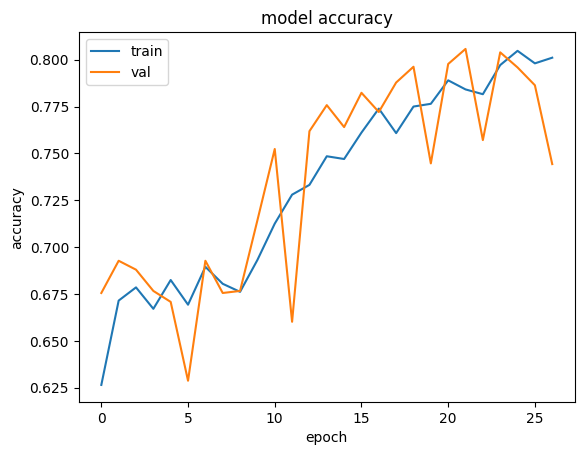

In [115]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Hybrid model (2) - model saved

In [ ]:
# Define the input shape for the CNN
num_sensors=1
input_shape = (X_train_seq.shape[1], num_sensors)


# Define the CNN model
cnn_input = Input(shape=input_shape)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
#conv4 = Conv1D(filters=512, kernel_size=3, activation='relu')(pool3)
#pool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(pool3)
cnn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flatten)
# cnn_output = Dense(128, activation='relu')(flatten)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Define the fully connected model

fc_input = Input(shape=(itemized_train_data.shape[1],))

concat = Concatenate()([cnn_output, fc_input])
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense2 = Dense(32, activation='relu')(dense1)
#dropout = Dropout(0.5)(dense1)
fc_output = Dense(1, activation='sigmoid')(dense2)

fc_model_2 = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
fc_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_3 = fc_model_2.fit([X_train_seq, itemized_train_data], y_train_1, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
342/342 [==============================] - 8s 21ms/step - loss: 1.3529 - accuracy: 0.6217 - val_loss: 0.7260 - val_accuracy: 0.3244
Epoch 2/50
342/342 [==============================] - 6s 17ms/step - loss: 0.6984 - accuracy: 0.6490 - val_loss: 0.8600 - val_accuracy: 0.4740
Epoch 3/50
342/342 [==============================] - 6s 17ms/step - loss: 0.6262 - accuracy: 0.6740 - val_loss: 0.6927 - val_accuracy: 0.6767
Epoch 4/50
342/342 [==============================] - 7s 21ms/step - loss: 0.6255 - accuracy: 0.6807 - val_loss: 0.6359 - val_accuracy: 0.6485
Epoch 5/50
342/342 [==============================] - 6s 18ms/step - loss: 0.6581 - accuracy: 0.6667 - val_loss: 0.5844 - val_accuracy: 0.7023
Epoch 6/50
342/342 [==============================] - 8s 22ms/step - loss: 0.6484 - accuracy: 0.6807 - val_loss: 0.5613 - val_accuracy: 0.7136
Epoch 7/50
342/342 [==============================] - 6s 17ms/step - loss: 0.6092 - accuracy: 0.6955 - val_loss: 0.5599 - val_accuracy: 0.7129

In [124]:
# Evaluate the performance of the model on the testing set
#X_test_seq = np.expand_dims(X_test.iloc[:,0].values, axis=2)
#x_test_features = np.asarray(itemized_test_data[:,1:]).astype('float32')
accuracy_3 = fc_model_2.evaluate([X_test_seq, itemized_test_data], y_test_1)[1]
print(f'Accuracy: {accuracy_3}')

143/143 [==============================] - 1s 10ms/step - loss: 0.4628 - accuracy: 0.8084
Accuracy: 0.8084266185760498


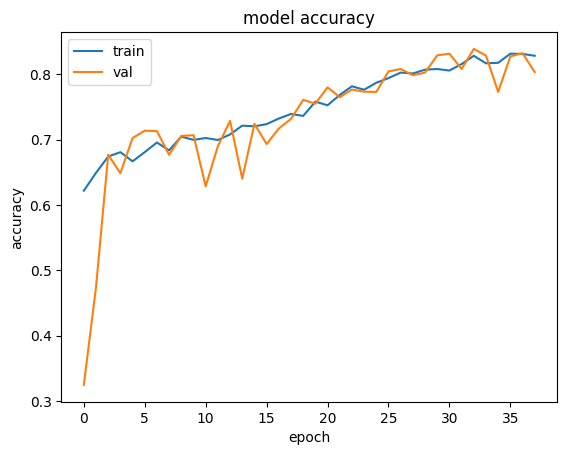

In [125]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

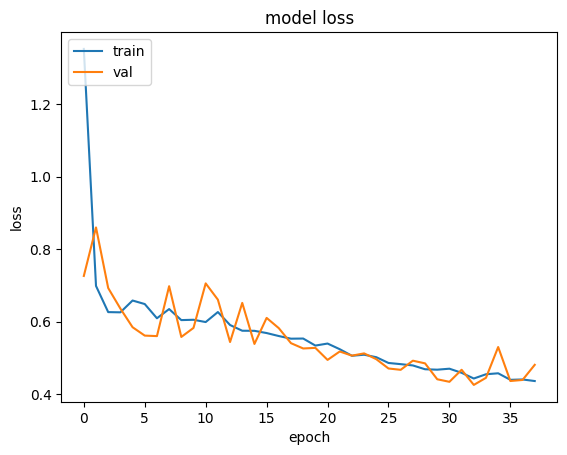

In [126]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [132]:
# save the model
fc_model_2.save(models_path+"hybrid_model_2_80")

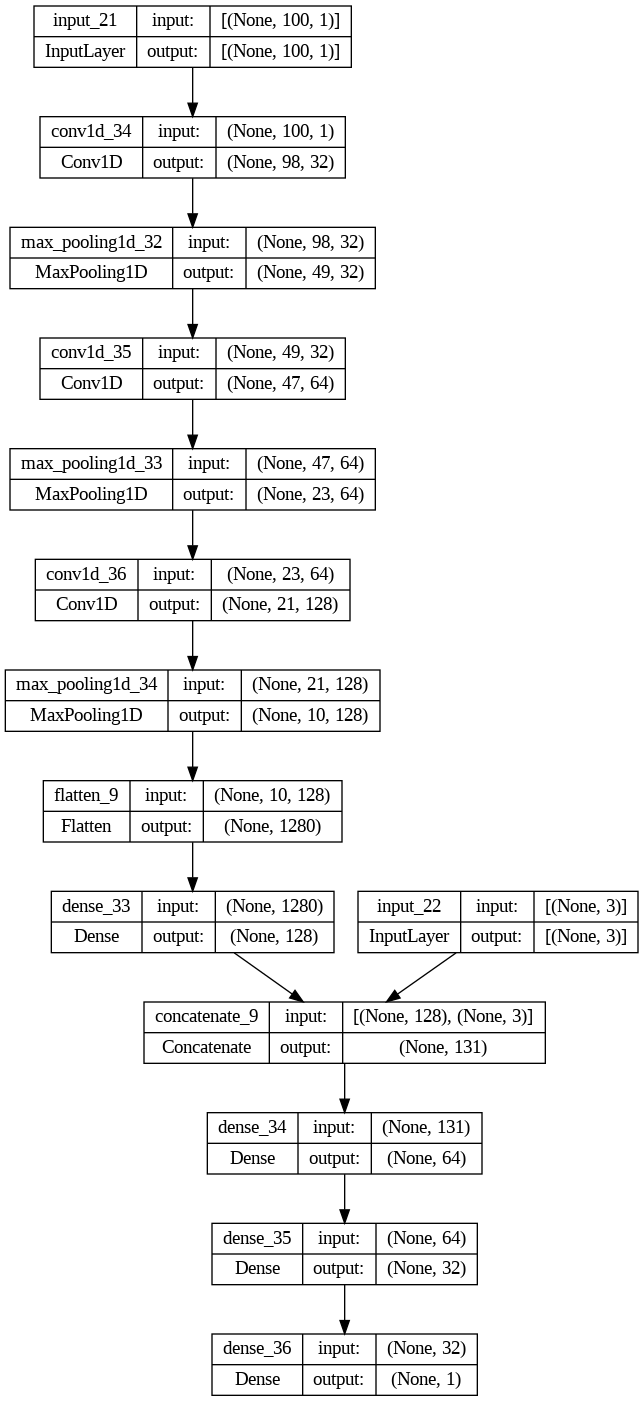

In [134]:
plot_model(fc_model_2, to_file=models_path+"hybrid_model_2_80.png", show_shapes=True,show_layer_names=True)

## hybrid model 3 saved (a bit overfitting)

In [141]:
# Define the input shape for the CNN
num_sensors=1
input_shape = (X_train_seq.shape[1], num_sensors)


# Define the CNN model
cnn_input = Input(shape=input_shape)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=2)(conv3)
conv4 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool3)
#pool4 = MaxPooling1D(pool_size=2)(conv4)
dropout = Dropout(0.5)(conv4)
flatten = Flatten()(dropout)
cnn_output = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)
# cnn_output = Dense(128, activation='relu')(flatten)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Define the fully connected model

fc_input = Input(shape=(itemized_train_data.shape[1],))

concat = Concatenate()([cnn_output, fc_input])
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense2 = Dense(32, activation='relu')(dense1)

fc_output = Dense(1, activation='sigmoid')(dense2)

fc_model_3 = Model(inputs=[cnn_input, fc_input], outputs=fc_output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
fc_model_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_4 = fc_model_3.fit([X_train_seq, itemized_train_data], y_train_1, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
342/342 [==============================] - 12s 30ms/step - loss: 1.4004 - accuracy: 0.6371 - val_loss: 0.6267 - val_accuracy: 0.6767
Epoch 2/50
342/342 [==============================] - 11s 31ms/step - loss: 0.7128 - accuracy: 0.6616 - val_loss: 0.8236 - val_accuracy: 0.6767
Epoch 3/50
342/342 [==============================] - 11s 31ms/step - loss: 0.6388 - accuracy: 0.6868 - val_loss: 0.5476 - val_accuracy: 0.7370
Epoch 4/50
342/342 [==============================] - 9s 27ms/step - loss: 0.6300 - accuracy: 0.7044 - val_loss: 0.7570 - val_accuracy: 0.6767
Epoch 5/50
342/342 [==============================] - 12s 35ms/step - loss: 0.6666 - accuracy: 0.7108 - val_loss: 0.5506 - val_accuracy: 0.7469
Epoch 6/50
342/342 [==============================] - 13s 37ms/step - loss: 0.5811 - accuracy: 0.7332 - val_loss: 0.5066 - val_accuracy: 0.7754
Epoch 7/50
342/342 [==============================] - 10s 29ms/step - loss: 0.5573 - accuracy: 0.7489 - val_loss: 0.8290 - val_accuracy: 

In [143]:
# Evaluate the performance of the model on the testing set

accuracy_4 = fc_model_3.evaluate([X_test_seq, itemized_test_data], y_test_1)[1]
print(f'Accuracy: {accuracy_4}')

143/143 [==============================] - 2s 12ms/step - loss: 0.3871 - accuracy: 0.8558
Accuracy: 0.855826199054718


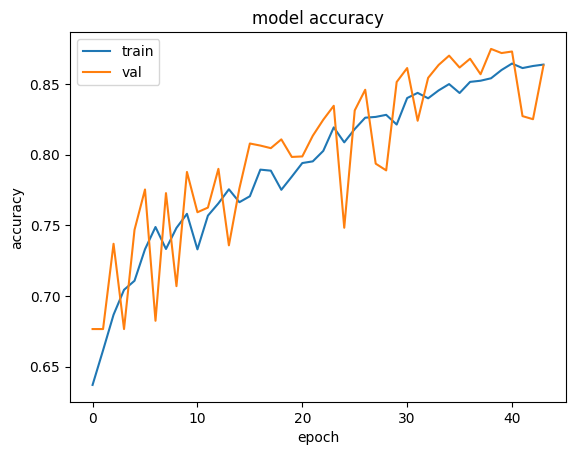

In [144]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

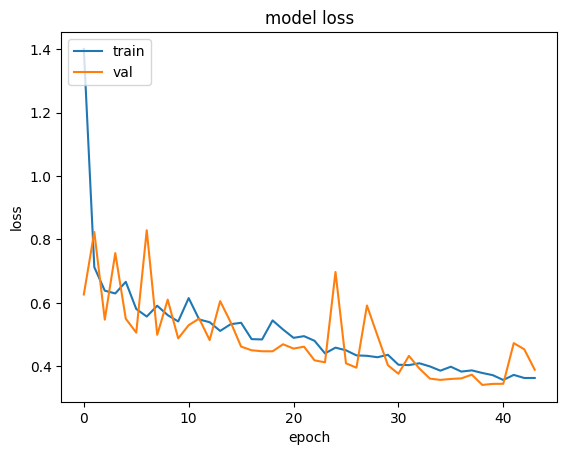

In [145]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [146]:
# save the model
fc_model_3.save(models_path+"hybrid_model_3_85")

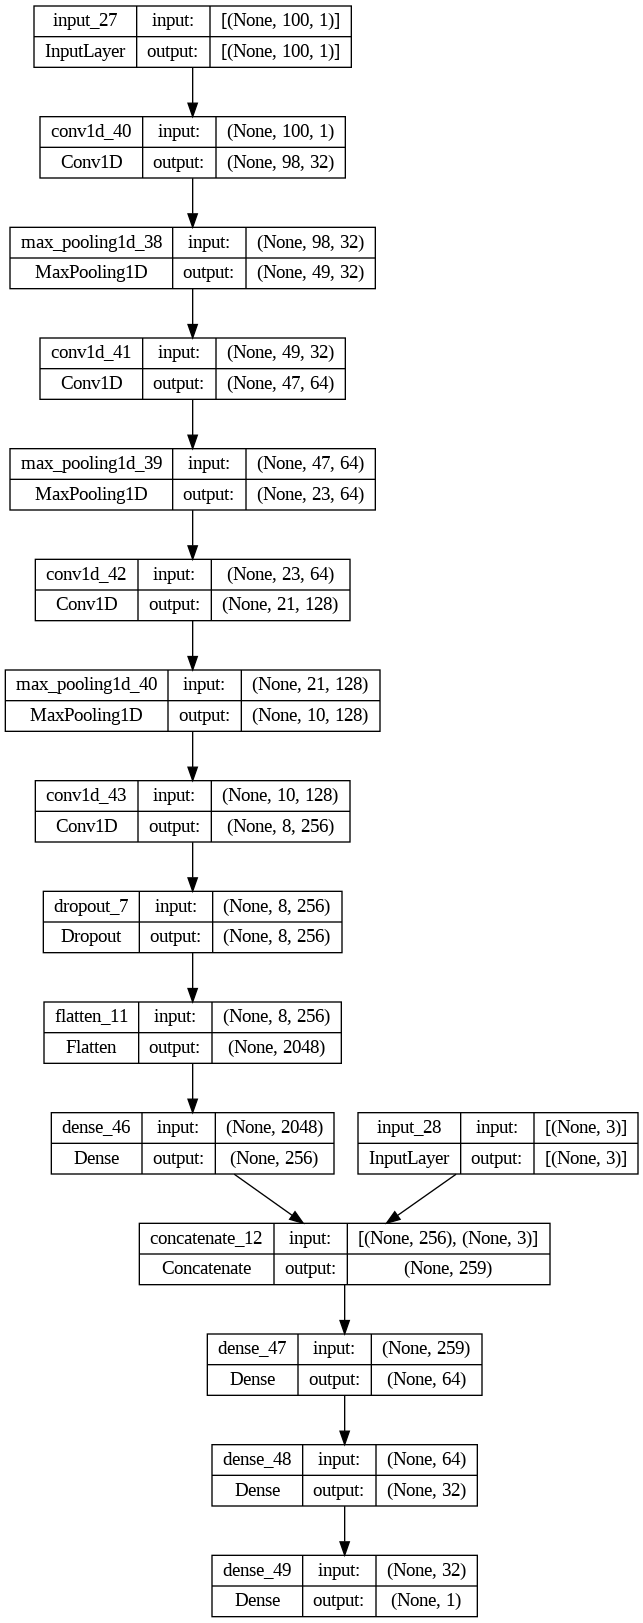

In [147]:
plot_model(fc_model_3, to_file=models_path+"hybrid_model_3_85.png", show_shapes=True,show_layer_names=True)

In [ ]:
when come back decide to use model 2 or 3.